# Deep Learning & Art: Neural Style Transfer


In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

## Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that.

In [ ]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

##  Neural Style Transfer
We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 
###  Computing the content cost

In [ ]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)

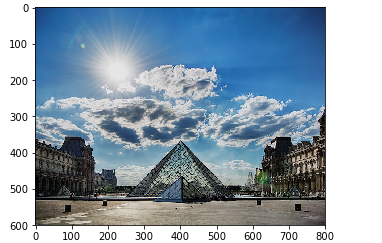

In [ ]:
def compute_content_cost(a_C, a_G):
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C,[n_C,n_W*n_H],name='a_C_unrolled')

    a_G_unrolled = tf.reshape(a_G,[n_C,n_W*n_H],name='a_G_unrolled')
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum((a_C_unrolled-a_G_unrolled)**2)/(4*n_H*n_W*n_C)
    
    
    return J_content

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

### Computing the style cost

In [ ]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)

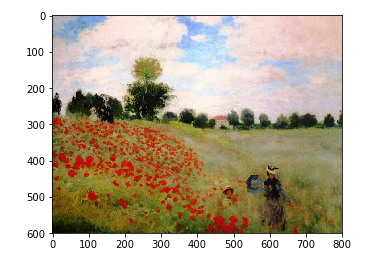

 ### Style matrix

In [2]:
def gram_matrix(A):
    GA = tf.matmul(A,A,transpose_b=True)
    
    return GA

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

 ### Style cost

In [3]:
def compute_layer_style_cost(a_S, a_G):
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W,n_C)
    a_S = tf.reshape(a_S,[n_H*n_W,n_C],name='a_S_unrolled')
    a_G = tf.reshape(a_G,[n_H*n_W,n_C],name='a_G_unrolled')

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/((2*n_C*n_H*n_W)**2)
    
    return J_style_layer

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

### Style Weights

In [ ]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [ ]:
def compute_style_cost(model, STYLE_LAYERS):

    # initialize the overall style cost
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### Defining the total cost to optimize

In [4]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha*J_content + beta*J_style
    
    return J

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

## Solving the optimization problem

In [ ]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [ ]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [ ]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

In [ ]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [ ]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [ ]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [ ]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
J = total_cost(J_content=J_content,J_style=J_style,alpha=10,beta=40)

In [ ]:
# define optimizer 
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

In [ ]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

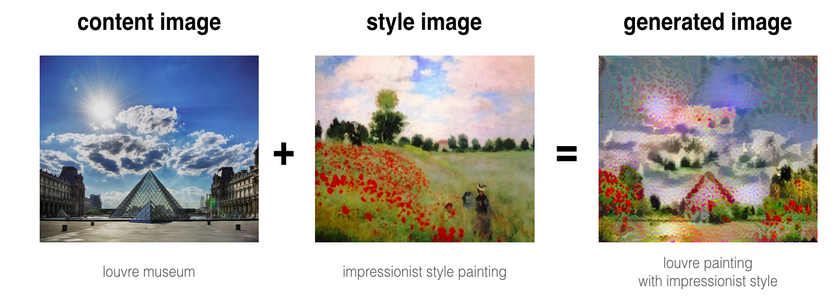

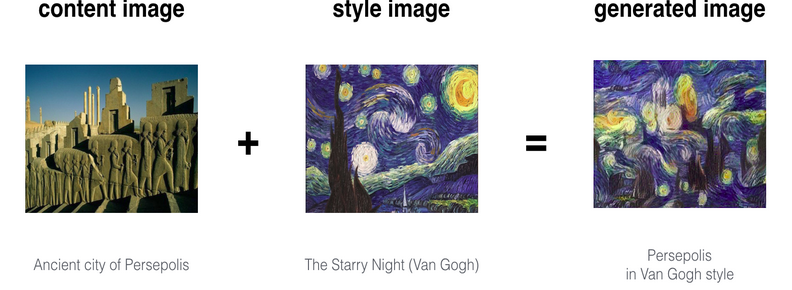